In [1]:
# Mask-based Curve Detection Model - PyTorch Implementation
# Updated by ChatGPT - May 2025

import os
import json
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# 1. Dataset
# =========================

class MaskDataset(Dataset):
    def __init__(self, data_dir, max_lines=3):
        self.data_dir = data_dir
        self.samples = [f for f in os.listdir(data_dir) if f.endswith(".json")]
        self.max_lines = max_lines

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        json_path = os.path.join(self.data_dir, self.samples[idx])
        with open(json_path, 'r') as f:
            sample = json.load(f)

        matrix = np.array(sample['data'], dtype=np.float32)  # [128, 128]
        matrix = torch.tensor(matrix).unsqueeze(0)  # [1, 128, 128]

        masks = []
        types = []

        for m in sample['masks']:
            types.append(m['type'])
            mask_array = np.array(m['mask'], dtype=np.uint8)  # [128, 128]
            masks.append(mask_array)

        # Padding to fixed number of masks (max_lines)
        while len(masks) < self.max_lines:
            masks.append(np.zeros_like(matrix.squeeze(0)))
            types.append(-1)

        masks = np.stack(masks[:self.max_lines])  # [max_lines, 128, 128]
        types = np.array(types[:self.max_lines])  # [max_lines]

        return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)



# class MaskDataset(Dataset):
#     def __init__(self, data_dir, max_lines=3):
#         self.data_dir = data_dir
#         self.samples = [f for f in os.listdir(data_dir) if f.endswith(".json")]
#         self.max_lines = max_lines

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         json_path = os.path.join(self.data_dir, self.samples[idx])
#         with open(json_path, 'r') as f:
#             sample = json.load(f)

#         matrix = np.array(sample['data'], dtype=np.float32) / 256. # [128, 128]
#         matrix = torch.tensor(matrix).unsqueeze(0)  # [1, 128, 128]

#         masks = []
#         types = []

#         for m in sample['lines']:
#             types.append(m['type'])
#             f = np.array(m['f'], dtype=np.uint8) / 128.  # [128, 128]
#             c = np.array(m['c'], dtype=np.uint8) / 128.  # [128, 128]
            
#             masks.append([f, c])

#         # Padding to fixed number of masks (max_lines)
#         while len(masks) < self.max_lines:
#             masks.append(np.zeros_like(matrix.squeeze(0)))
#             types.append(-1)

#         masks = np.stack(masks[:self.max_lines])  # [max_lines, 128, 128]
#         types = np.array(types[:self.max_lines])  # [max_lines]

#         return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)


In [2]:
class MaskTypeTransformer(nn.Module):
    def __init__(self, in_channels=1, num_types=4, max_lines=3, embed_dim=256):
        super().__init__()
        self.max_lines = max_lines
        self.num_types = num_types

        # CNN feature extractor
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  # [B, 1, 128, 128] -> [B, 32, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 64, 64]
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 32, 32]
            nn.Conv2d(64, embed_dim, 3, padding=1),
            nn.ReLU(),        # [B, 256, 32, 32]
        )

        # Transformer encoder over flattened spatial features
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8,batch_first=True)  # ✅ 添加这个参数
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Mask head - Upsample to (512, 128)
        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),         # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, max_lines, kernel_size=2, stride=2),   # 128x128 -> 256x256
            nn.ReLU(),
            nn.Conv2d(max_lines, max_lines, kernel_size=3, padding=1),
            nn.Upsample(size=(512, 128), mode="bilinear", align_corners=False)  # 输出尺寸统一
        )

        # Type head - predict [max_lines, num_types]
        self.type_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),  # [B, C, 1, 1] -> [B, C]
            nn.Linear(embed_dim, max_lines * num_types)
        )

    def forward(self, x):
        feats = self.backbone(x)  # [B, 256, 32, 32]
        B, C, H, W = feats.shape
        flattened = feats.view(B, C, -1).permute(2, 0, 1)  # [HW, B, C]
        encoded = self.transformer(flattened).permute(1, 2, 0).view(B, C, H, W)

        masks = self.mask_head(encoded)  # [B, max_lines, 512, 128]

        types = self.type_head(encoded)  # [B, max_lines * num_types]
        types = types.view(B, self.max_lines, self.num_types)  # [B, max_lines, num_types]
        return masks, types


In [3]:
# =========================
# 5. Visualization
# =========================

def visualize_masks(matrix, pred_masks, threshold=0.5, j=0):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
    pred_masks = torch.sigmoid(pred_masks)
    for i in range(pred_masks.shape[0]):
        mask = pred_masks[i] > threshold
        if mask.sum() > 0:
            ax.contour(mask.cpu().numpy(), levels=[0.5], colors=[f"C{i}"])
    ax.set_title("Predicted Masks")
    fig.savefig(f'save/{j:05d}.png')
    plt.show()

In [66]:
# =========================
# 6. Run Example
# =========================
import os


data_dir = "datasets_json"
dataset = MaskDataset(data_dir)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = MaskTypeTransformer().cuda()
model_path = 'checkpoints/mask_type_transformer_00140.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))


<All keys matched successfully>

Text(0.5, 1.0, 'Predicted Masks')

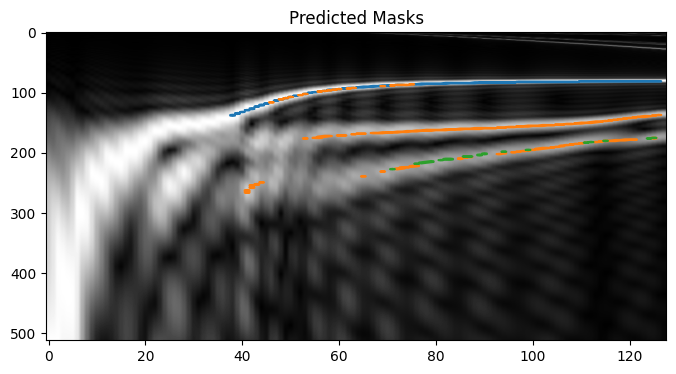

In [78]:
# 可视化最后一个 batch 的第一个样本
import random
# 从 DataLoader 随机抽取一个 batch
device = 'cuda'

x, y_masks, y_types = next(iter(loader))

i = 1
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())

threshold = 0.1
matrix = x[i]
pred_mask = pred_masks[i]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
pred_mask = torch.sigmoid(pred_mask)
for i in range(pred_mask.shape[0]):
    mask = pred_mask[i] > threshold
    if mask.sum() > 0:
        ax.contour(mask.cpu().numpy(), levels=[0.5], colors=[f"C{i}"])
ax.set_title("Predicted Masks")

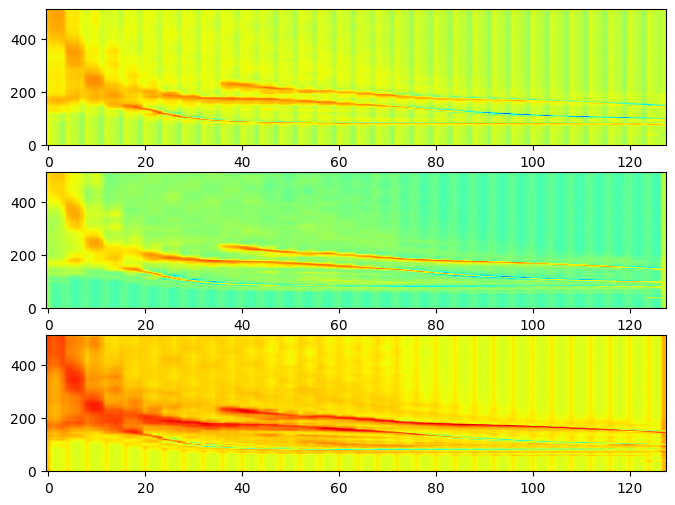

In [79]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].imshow(pred_masks[i][0].squeeze().cpu(), cmap='jet', aspect='auto',origin='lower')
axes[1].imshow(pred_masks[i][1].squeeze().cpu(), cmap='jet', aspect='auto',origin='lower')
axes[2].imshow(pred_masks[i][2].squeeze().cpu(), cmap='jet', aspect='auto',origin='lower')

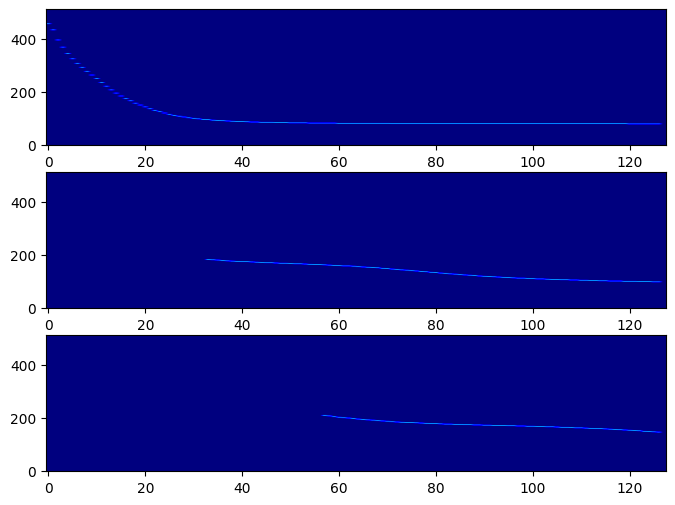

: 

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].imshow(y_masks[i][0].squeeze().cpu(), cmap='jet', aspect='auto',origin='lower')
axes[1].imshow(y_masks[i][1].squeeze().cpu(), cmap='jet', aspect='auto',origin='lower')
axes[2].imshow(y_masks[i][2].squeeze().cpu(), cmap='jet', aspect='auto',origin='lower')

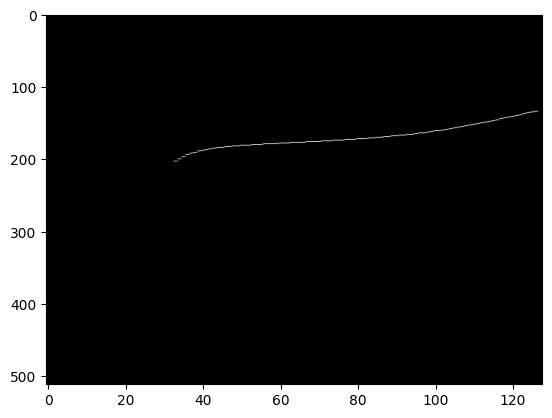

In [ ]:
j = 1
plt.imshow(y_masks[i][j].squeeze().cpu(), cmap='gray', aspect='auto')

In [12]:
x.shape, y_masks.shape, pred_masks.shape

(torch.Size([16, 1, 512, 128]),
 torch.Size([16, 3, 512, 128]),
 torch.Size([16, 3, 512, 128]))

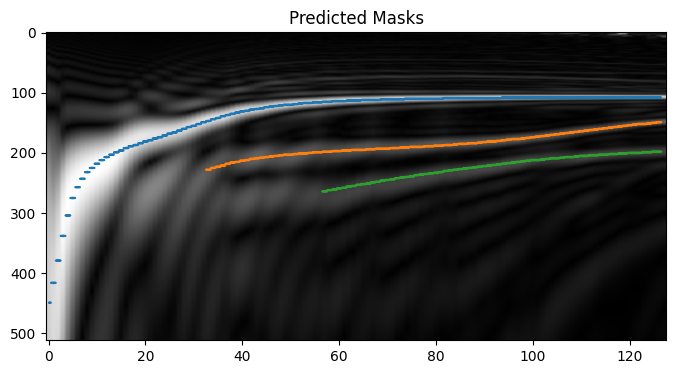

In [ ]:
i = 5
visualize_masks(x[i], y_masks[i])

In [11]:
# 可视化最后一个 batch 的第一个样本
x, y_masks, y_types = next(iter(loader))

i = 10
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())
# visualize_masks(x[i], pred_masks[i])
